In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

main_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners' + '\\'
processed_data_directory = main_directory + r'data\processed data' + '\\'

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, LogisticRegression
from sklearn import datasets, tree, utils
from sklearn import model_selection, ensemble
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [7]:
import spacy
# nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
from sklearn.naive_bayes import MultinomialNB

In [8]:
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

# classifier model

Regression is tricky with little data. Let's classify each inspection to the nearest 10, and try that.

In [31]:
roundup(14.99)

NameError: name 'roundup' is not defined

In [24]:
np.round(15,10)

15

In [12]:
round(0.5)

1

In [35]:
import math

In [42]:
df.Score.apply(lambda x: math.ceil(x / 5) * 5).value_counts()

95     73111
90     49350
100    45935
85     24646
80     13506
75      7139
70      2160
65       657
55        65
60        46
45         2
Name: Score, dtype: int64

(array([2.0000e+00, 6.5000e+01, 4.6000e+01, 8.4200e+02, 3.7880e+03,
        9.1600e+03, 2.0858e+04, 3.8106e+04, 8.2092e+04, 6.1658e+04]),
 array([ 44. ,  49.6,  55.2,  60.8,  66.4,  72. ,  77.6,  83.2,  88.8,
         94.4, 100. ]),
 <BarContainer object of 10 artists>)

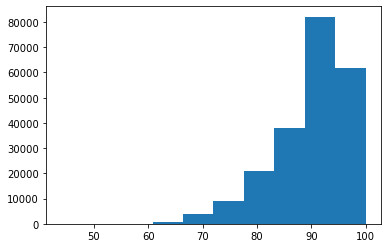

In [45]:
plt.hist(df.Score.apply(round))